In [2]:
%load_ext autoreload
%autoreload 2
import pickle
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd

import data_pre_processing
import dataset_pre_processing
import pre_training
import raw_data_processing
from raw_data_processing import process_PAMAP2_all_data, process_hhar_all_files, process_motion_sense_all_files, open_pickle
import numpy as np
import scipy.stats
import data_pre_processing
import self_har_models
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import wandb

tf.get_logger().setLevel('INFO')

# Data pre-processing

In [3]:
# get data from pickle 

with open('pickled_datasets/pamap2.pickle', 'rb') as file:
    pamap_df = pickle.load(file)
with open('pickled_datasets/hhar2.pickle', 'rb') as file:
    hhar_df = pickle.load(file)
with open('pickled_datasets/motionsense2.pickle', 'rb') as file:
    motion_sense_df = pickle.load(file)
    
def concat_datasets(datasets, sensor_type):
    concated_datasets = {}
    ##TODO need to check key to see whether mag exists
    for df in datasets:
        concated_datasets.update(df[sensor_type])
    return concated_datasets

cdf = concat_datasets([pamap_df, hhar_df, motion_sense_df], "all")
def get_labels(data):
    all_labels = []
    for user in data:
        all_labels = np.concatenate((np.unique(data[user][0][1]), all_labels))
    labels = np.unique(all_labels)
    return labels

labels = get_labels(cdf)
label_map = {label: index for index, label in enumerate(labels)}
print(label_map)
user_datasets_processed = data_pre_processing.pre_process_dataset_composite(
    cdf, label_map, 14, 
    ['101', '102', '103', '104', '105', '106', '107', 'a', 'b', 'c', 'd', 'e', 'f', 'g', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'], 
    ["108", "109", "h", "i", "21", "22", "23", "24"], 400, 200
)

{'IMU ankle acc': 0, 'IMU ankle gyro': 1, 'IMU ankle mag': 2, 'IMU chest acc': 3, 'IMU chest gyro': 4, 'IMU chest mag': 5, 'IMU hand acc': 6, 'IMU hand gyro': 7, 'IMU hand mag': 8, 'Phone acc': 9, 'Phone gyro': 10, 'Watch acc': 11, 'Watch gyro': 12, 'iphone Acc': 13}
getting mean
[-0.5407976  -1.98511375  1.75847852]
[12.59890847 11.8476798  11.12922508]
normalising train set
normalisnig test


In [4]:
# implement early stopping
callback = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Create CNN-LSTM-Model

In [4]:
inputs = tf.keras.Input(shape=(400,3), name='input')
x = inputs
x = tf.keras.layers.Dense(300, activation='relu')(x)
x = tf.keras.layers.Conv1D(
        64, 3,
        activation='relu',
        strides = 1,
        kernel_regularizer=tf.keras.regularizers.l2(l=1e-4)
    )(x)
x = tf.keras.layers.Conv1D(
        128, 3,
        activation='relu',
        strides = 1,
        kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.MaxPool1D(pool_size=4, padding='valid', data_format='channels_last', strides=2)(x)

x = tf.keras.layers.Conv1D(
    128, 5,
    activation='relu',
    strides = 2,
    kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.Conv1D(
    256, 5,
    activation='relu',
    strides = 2,
    kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.MaxPool1D(pool_size=4, padding='valid', data_format='channels_last', strides=2)(x)

x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(96))(x)
x = tf.keras.layers.Dropout(0.4)(x)
# x = tf.keras.layers.Dense(96, activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='softmax')(x)

CNNLSTN_model = tf.keras.Model(inputs, x, name="CNN-LSTM")
full_CNNLSTM_model = self_har_models.attach_full_har_classification_head(CNNLSTN_model, 14, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))
print(CNNLSTN_model.summary())
print(full_CNNLSTM_model.summary())

Model: "CNN-LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 400, 3)]          0         
                                                                 
 dense_4 (Dense)             (None, 400, 300)          1200      
                                                                 
 conv1d_4 (Conv1D)           (None, 398, 64)           57664     
                                                                 
 conv1d_5 (Conv1D)           (None, 396, 128)          24704     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 197, 128)         0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 97, 128)           82048     
                                                          

In [6]:
CNNLSTM_history = full_CNNLSTM_model.fit(user_datasets_processed[0][0], user_datasets_processed[0][1]
                    , epochs=100, validation_data=(user_datasets_processed[1][0], user_datasets_processed[1][1]), callbacks=[callback])

Epoch 1/100
5821/5821 [==============================] - 58s 9ms/step - loss: 0.9034 - categorical_accuracy: 0.6985 - auc: 0.9677 - precision: 0.7643 - recall: 0.6155 - val_loss: 0.6569 - val_categorical_accuracy: 0.7843 - val_auc: 0.9825 - val_precision: 0.8495 - val_recall: 0.6967
Epoch 2/100
5821/5821 [==============================] - 53s 9ms/step - loss: 0.6091 - categorical_accuracy: 0.8005 - auc: 0.9850 - precision: 0.8557 - recall: 0.7410 - val_loss: 0.5058 - val_categorical_accuracy: 0.8395 - val_auc: 0.9898 - val_precision: 0.9120 - val_recall: 0.7501
Epoch 3/100
5821/5821 [==============================] - 53s 9ms/step - loss: 0.4502 - categorical_accuracy: 0.8523 - auc: 0.9914 - precision: 0.9004 - recall: 0.8165 - val_loss: 0.3635 - val_categorical_accuracy: 0.8727 - val_auc: 0.9946 - val_precision: 0.9168 - val_recall: 0.8388
Epoch 4/100
5821/5821 [==============================] - 53s 9ms/step - loss: 0.3523 - categorical_accuracy: 0.8849 - auc: 0.9943 - precision: 0.923

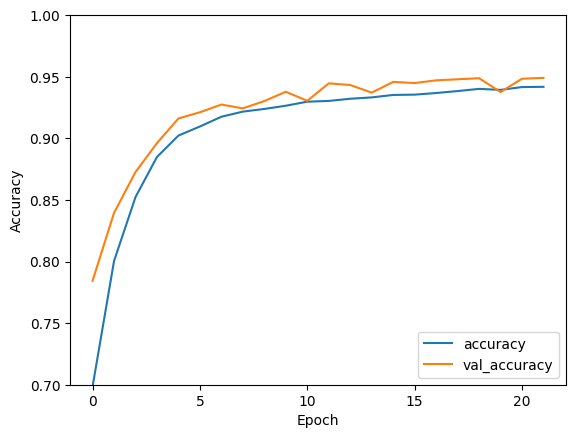

1504/1504 [==============================] - 5s 3ms/step


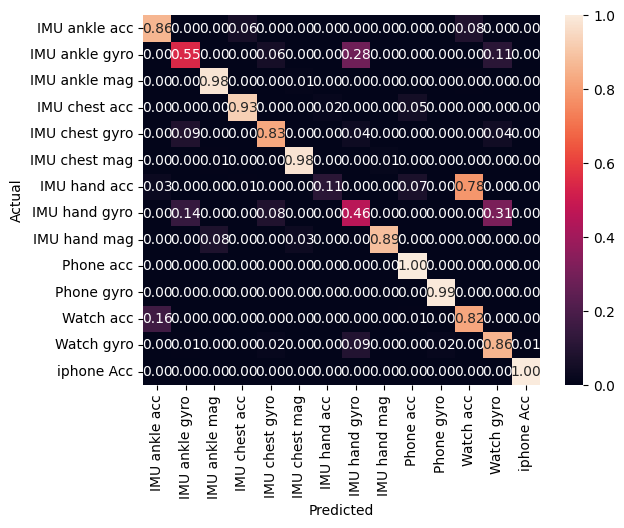

In [7]:
import matplotlib.pyplot as plt
plt.plot(CNNLSTM_history.history['categorical_accuracy'], label='accuracy')
plt.plot(CNNLSTM_history.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.7, 1])
plt.legend(loc='lower right')
plt.show()

lstm_test_result = full_CNNLSTM_model.evaluate(user_datasets_processed[2][0],  user_datasets_processed[2][1], return_dict=True)
predicted_labels = np.argmax(full_CNNLSTM_model.predict(user_datasets_processed[2][0]), axis=1)
true_labels = np.argmax(user_datasets_processed[2][1], axis=1)
confusion_mat = tf.math.confusion_matrix(true_labels, predicted_labels)
cm = confusion_mat.numpy()
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [9]:
full_CNNLSTM_model.save("CNN-LSTM")

INFO:tensorflow:Assets written to: CNN-LSTM/assets


INFO:tensorflow:Assets written to: CNN-LSTM/assets


In [10]:
model = tf.keras.models.load_model('CNN-LSTM')

In [11]:
lstm_test_result = model.evaluate(user_datasets_processed[2][0],  user_datasets_processed[2][1], return_dict=True)


660/660 [==============================] - 4s 4ms/step - loss: 0.6365 - categorical_accuracy: 0.8919 - auc: 0.9527 - precision: 0.8922 - recall: 0.8888


# Downstream Train

In [8]:
with open('pickled_datasets/hhar_HAR.pickle', 'rb') as file:
    hhar_df = pickle.load(file)
core_model = self_har_models.extract_core_model(full_CNNLSTM_model)
def get_labels(data):
    all_labels = []
    for user in data:
        all_labels = np.concatenate((np.unique(data[user][0][1]), all_labels))
    labels = np.unique(all_labels)
    return labels

labels = get_labels(hhar_df)
label_map = {label: index for index, label in enumerate(labels)}
print(label_map)
user_datasets_processed = data_pre_processing.pre_process_dataset_composite(
hhar_df, label_map, 6,
    ['a', 'b', 'c', 'd', 'e', 'f', 'g'],
['h', 'i'], 400, 200)
full_CNNLSTM_model = self_har_models.attach_full_har_classification_head(core_model, 6, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))
CNNLSTM_history = full_CNNLSTM_model.fit(user_datasets_processed[0][0], user_datasets_processed[0][1]
                    , epochs=100, validation_data=(user_datasets_processed[1][0], user_datasets_processed[1][1]), callbacks=[callback])

{'bike': 0, 'sit': 1, 'stairsdown': 2, 'stairsup': 3, 'stand': 4, 'walk': 5}
getting mean
[-1.53514467  0.15958888  8.87110299]
[4.05960663 1.57266006 2.32821487]
normalising train set
normalisnig test
Epoch 1/100
1089/1089 [==============================] - 13s 9ms/step - loss: 0.7856 - categorical_accuracy: 0.6507 - auc: 0.9340 - precision: 0.9335 - recall: 0.4402 - val_loss: 0.6721 - val_categorical_accuracy: 0.6734 - val_auc: 0.9471 - val_precision: 0.9741 - val_recall: 0.4800
Epoch 2/100
1089/1089 [==============================] - 9s 9ms/step - loss: 0.6782 - categorical_accuracy: 0.6756 - auc: 0.9464 - precision: 0.9607 - recall: 0.4791 - val_loss: 0.6474 - val_categorical_accuracy: 0.6838 - val_auc: 0.9500 - val_precision: 0.9705 - val_recall: 0.4905
Epoch 3/100
1089/1089 [==============================] - 9s 9ms/step - loss: 0.6592 - categorical_accuracy: 0.6810 - auc: 0.9486 - precision: 0.9670 - recall: 0.4831 - val_loss: 0.6213 - val_categorical_accuracy: 0.7105 - val_auc: 

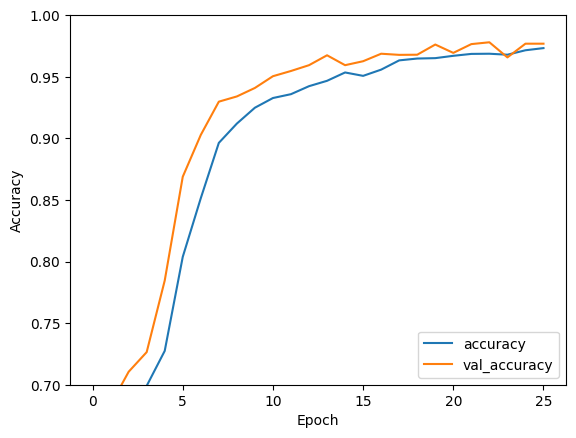

401/401 [==============================] - 2s 3ms/step


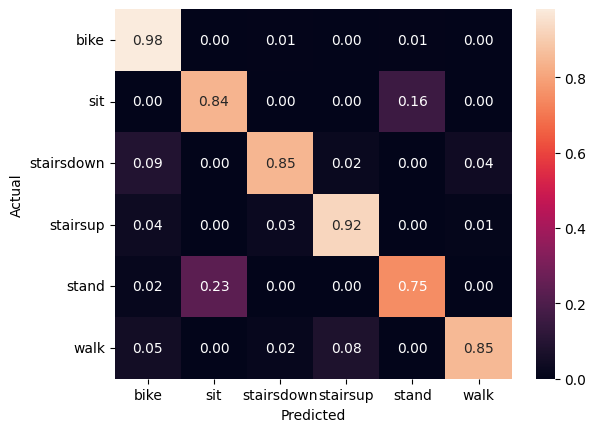

In [10]:
import matplotlib.pyplot as plt
plt.plot(CNNLSTM_history.history['categorical_accuracy'], label='accuracy')
plt.plot(CNNLSTM_history.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.7, 1])
plt.legend(loc='lower right')
plt.show()

lstm_test_result = full_CNNLSTM_model.evaluate(user_datasets_processed[2][0],  user_datasets_processed[2][1], return_dict=True)
predicted_labels = np.argmax(full_CNNLSTM_model.predict(user_datasets_processed[2][0]), axis=1)
true_labels = np.argmax(user_datasets_processed[2][1], axis=1)
confusion_mat = tf.math.confusion_matrix(true_labels, predicted_labels)
cm = confusion_mat.numpy()
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)